<a href="https://colab.research.google.com/github/sungjindo/black_coal_price/blob/main/Prophet_%EB%B3%80%ED%99%94%EC%9C%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.모듈 불러오기**








In [ ]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import os

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object
%matplotlib notebook
%matplotlib inline

# 통계 및 기계학습 관련 라이브러리
from scipy import stats    # 통계 관련 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV    # 데이터 셋 분류 라이브러리
from sklearn.utils import resample    # 데이터 업샘플링&다운샘플링 라이브러리
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN    # 복합샘플링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler    # 데이터 스케일링 라이브러리
from statsmodels.stats.outliers_influence import variance_inflation_factor    # 변수 간 다중공선성 확인(VIF) 라이브러리
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)    # 모델 정확도 검증 라이브러리
from sklearn.model_selection import cross_val_score, train_test_split   # validation  검증 라이브러리

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import statsmodels.api as sm    # 통계분석 관련 라이브러리
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error


import warnings    # 경고문구 지우기
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Mounted at /content/gdrive


# **2.data**


In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-04-01']
df = df.reset_index()
df = df[['date','iron']]
df

,date,iron
0,2011-01-01,168.30
1,2011-01-02,168.30
2,2011-01-03,170.00
3,2011-01-04,172.10
4,2011-01-05,174.50
...,...,...
3007,2019-03-27,85.72
3008,2019-03-28,85.64
3009,2019-03-29,85.70
3010,2019-03-30,85.70


In [ ]:
df1 = df['iron'].shift(1)
df1

0          NaN
1       168.30
2       168.30
3       170.00
4       172.10
         ...  
3007     85.80
3008     85.72
3009     85.64
3010     85.70
3011     85.70
Name: iron, Length: 3012, dtype: float64

In [ ]:
df2 = df[['date','iron']]
df2['iron'] = df1
df_cha1 = df2['iron']-df['iron']
df_cha = df_cha1 / df2['iron']
df_cha=df_cha.bfill()
df_cha

0       0.000000
1       0.000000
2      -0.010101
3      -0.012353
4      -0.013945
          ...   
3007    0.000932
3008    0.000933
3009   -0.000701
3010    0.000000
3011    0.000000
Name: iron, Length: 3012, dtype: float64

In [ ]:
df2['iron'] = df_cha
df2 = df2.rename(columns={'iron':'iron_cha'})
df2

,date,iron_cha
0,2011-01-01,0.000000
1,2011-01-02,0.000000
2,2011-01-03,-0.010101
3,2011-01-04,-0.012353
4,2011-01-05,-0.013945
...,...,...
3007,2019-03-27,0.000932
3008,2019-03-28,0.000933
3009,2019-03-29,-0.000701
3010,2019-03-30,0.000000


#3.Prameter조정 prophet model

1.   Trend

*   **changepoints**	트렌드 변화시점을 명시한 리스트값
*  **changepoint_prior_scale**	changepoint(trend) 의 유연성 조절
*   **n_changepoints**	changepoint 의 개수
*   **changepoint_range**	changepoint 설정 가능 범위. (기본적으로 데이터 중 80% 범위 내에서 changepoint를 설정합니다.)


2.   **Seasonality**
*  **yearly_seasonality**	연 계절성
*  **weekly_seasonality**	주 계절성
*  **daily_seasonality**	일 계절성
*  **seasonality_prior_scale**	계절성 반영 강도
*  **seasonality_mode**	‘additive ‘ 인지 ‘multiplicative’ 인지


In [ ]:
m.predict(last_1year)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,-0.000494,-0.022007,0.014017,-0.000494,-0.000494,-0.003181,-0.003181,-0.003181,-0.000188,...,0.000062,0.000062,0.000062,-0.003055,-0.003055,-0.003055,0.0,0.0,0.0,-0.003675
1,2019-01-02,-0.000494,-0.018083,0.017466,-0.000494,-0.000494,-0.000902,-0.000902,-0.000902,0.001373,...,0.000672,0.000672,0.000672,-0.002947,-0.002947,-0.002947,0.0,0.0,0.0,-0.001396
2,2019-01-03,-0.000494,-0.018475,0.017455,-0.000494,-0.000494,0.000808,0.000808,0.000808,0.002942,...,0.000675,0.000675,0.000675,-0.002809,-0.002809,-0.002809,0.0,0.0,0.0,0.000314
3,2019-01-04,-0.000494,-0.019139,0.016781,-0.000494,-0.000494,-0.000357,-0.000357,-0.000357,0.003491,...,-0.001203,-0.001203,-0.001203,-0.002644,-0.002644,-0.002644,0.0,0.0,0.0,-0.000851
4,2019-01-05,-0.000494,-0.017851,0.017324,-0.000494,-0.000494,0.000089,0.000089,0.000089,0.002665,...,-0.000118,-0.000118,-0.000118,-0.002458,-0.002458,-0.002458,0.0,0.0,0.0,-0.000405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2019-03-27,-0.000496,-0.015822,0.019922,-0.000496,-0.000496,0.002177,0.002177,0.002177,-0.000357,...,0.000672,0.000672,0.000672,0.001862,0.001862,0.001862,0.0,0.0,0.0,0.001681
86,2019-03-28,-0.000496,-0.017827,0.019237,-0.000496,-0.000496,0.002491,0.002491,0.002491,-0.000115,...,0.000675,0.000675,0.000675,0.001931,0.001931,0.001931,0.0,0.0,0.0,0.001995
87,2019-03-29,-0.000496,-0.017187,0.018332,-0.000496,-0.000496,0.001042,0.001042,0.001042,0.000266,...,-0.001203,-0.001203,-0.001203,0.001979,0.001979,0.001979,0.0,0.0,0.0,0.000545
88,2019-03-30,-0.000496,-0.017307,0.020209,-0.000496,-0.000496,0.002165,0.002165,0.002165,0.000279,...,-0.000118,-0.000118,-0.000118,0.002004,0.002004,0.002004,0.0,0.0,0.0,0.001669


##3.1 **Prophet model(all/3month)**
  -all 
  -3개월 prophet prediction


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.006
MAPE: 1958852116434.268


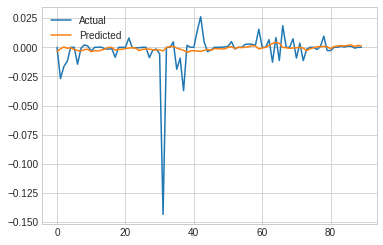

In [ ]:


#a = prophetm(z, x, y) 



df2.columns = ['ds', 'y']
df2['ds']= pd.to_datetime(df2['ds'])


train = df2.drop(df.index[-12:])
y_true = df2['y'][-90:].values 
# shellscript

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
m = Prophet(
# trend
        changepoint_prior_scale= 0.1,
# seasonality
        weekly_seasonality='auto',
        yearly_seasonality='auto',
      daily_seasonality='auto',
      seasonality_prior_scale=10,
      holidays_prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(train).predict(last_1year)
# fig = m.plot_components(forecast)
# a = add_changepoints_to_plot(fig.gca(), m, forecast)
y_pred = forecast['yhat'].values

last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])
y_tr = df2 
y_tr['ds']=last_1year['ds']
y_tr=y_tr.dropna()
y_tr['y']= y_true

y_tr = y_tr.rename(columns ={'y':'y_true'})
y_true = y_tr['y_true'].values
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()



# changepoint_prior_scale= a / 0.05
# seasonality_prior_scale=b /10
# holidays_prior_scale = c /10
# period = d /30.5
# fourier_order=e /1~5?

# def def __init__(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, 
# yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, 
# seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, 
# mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)

# print('-------------done------------')
# print('y_pred result: {} '  .format(y_pred))


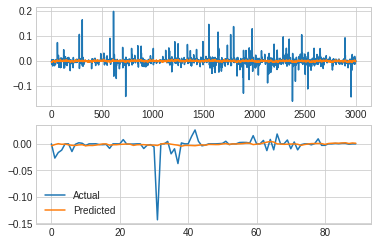

In [ ]:
plt.subplot(211)
plt.plot(train['y'].values, label='Actual')
plt.plot(m.predict(train)['yhat'].values, label='Predicted')


plt.subplot(212)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()